##Seq2seq으로 번역기 만들기

개발 환경
<br/>데이터 정보


데이터 전처리
<br/>중복 제거
<br/>정제
<br/>토큰화

모델 구성
<br/>Seq2seq with Attention
<br/>Optimizer & Loss
<br/>Train Step
<br/>Evaluation

모델 학습
<br/>Hyperparameter
<br/>Model Initialization
<br/>First Model
<br/>Second Model
<br/>Third Model
<br/>Fourth Model
<br/>FModel Selection

최종 모델
<br/>Epoch Test
<br/>Model Evaluation
<br/>Random State

결론
<br/>참고문헌

#개발 환경

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

한글 폰트를 설치한다.
<br/>혹시 깨짐현상이 발생하는 경우 런타임을 다시 시작하고 matplotlib 모듈을 실행하면 한글이 출력된다.

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker

In [ ]:
font_list = [font.name for font in fm.fontManager.ttflist]
font_list

Google Colab에 한글 폰트가 설치되어 있는지 확인한다.

In [ ]:
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

Attention Map을 확인하기 위해 한국어를 지원하는 폰트로 변경한다.

In [ ]:
import os
# install konlpy, jdk, JPype
!pip install konlpy
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip3 install JPype1-py3

# install mecab-ko
os.chdir('/tmp/')
!curl -LO https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
!tar zxfv mecab-0.996-ko-0.9.2.tar.gz
os.chdir('/tmp/mecab-0.996-ko-0.9.2')
!./configure
!make
!make check
!make install

# install mecab-ko-dic
!apt-get install automake
os.chdir('/tmp')
!curl -LO https://bitbucket.org/eunjeon/mecab-ko-dic/downloads/mecab-ko-dic-2.1.1-20180720.tar.gz
!tar -zxvf mecab-ko-dic-2.1.1-20180720.tar.gz
os.chdir('/tmp/mecab-ko-dic-2.1.1-20180720')
!./autogen.sh
!./configure
!make
!make install

# install mecab-python
os.chdir('/content')
!git clone https://bitbucket.org/eunjeon/mecab-python-0.996.git
os.chdir('/content/mecab-python-0.996')
!python3 setup.py build
!python3 setup.py install

In [ ]:
import os
import io
import time
import random

In [ ]:
from tqdm import tqdm
from IPython.display import Image
from IPython.display import HTML

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split

In [ ]:
import re
from konlpy.tag import Mecab
from keras.preprocessing.text import Tokenizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip freeze > '/content/drive/MyDrive/lms/library_version.txt'

In [ ]:
library_name = ['matplotlib=', 'scikit-learn=', 'tensorflow=', 'pandas=', 'numpy=',
                'tqdm=', 'regex=', 'konlpy=', 'keras=']
library_version = []
count = 0

import sys
print(sys.version)
print()

with open('/content/drive/MyDrive/lms/library_version.txt', 'r') as f:
    lines = f.read().splitlines() 

for i in range(len(lines)):
  for line in lines[i:i+1]:
    for library in library_name:
      if library in line:
        library_version.append(line)
        count += 1
        print(line, end = '    ')
        if count % 3 == 0:
          print()

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

keras==2.8.0      konlpy==0.6.0      matplotlib==3.2.2     
numpy==1.21.6      pandas==1.3.5      regex==2022.6.2     
scikit-learn==1.0.2      sklearn-pandas==1.8.0      tensorflow==2.8.2+zzzcolab20220527125636     
tqdm==4.64.0     


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Google Colab에서 할당된 GPU를 확인한다.
<br/>고용량 메모리 VM에 액세스한다

#데이터 정보

[Korean Parallel Corpora](https://github.com/jungyeul/korean-parallel-corpora)

한국어의 형태소 분석과 품사 태깅, 기계 번역 연구를 위해 공개된 데이터이다.

한국어-영어 뉴스 병렬 코퍼스
<br/>한국어-영어 Junior High Evaluation 병렬 코퍼스
<br/>한국어-프랑스 병렬 코퍼스
<br/>북한어-영어 병렬 코퍼스

[Korean English News V1](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

한국어-영어 뉴스 병렬 코퍼스이다.

In [ ]:
path_to_ko = '/content/drive/MyDrive/lms/seq2seq_translation/korean_parallel_corpora/korean-english-park.train.ko'

with open(path_to_ko, "r") as f:
    ko_raw = f.read().splitlines()

print("Data Size :", len(ko_raw))
print()
print("Example")
for ko_sen in ko_raw[600:700][::20]: print("", ko_sen)

Data Size : 94123

Example
 앞서가고 있는 은행 중의 하나가 오하이오 주 콜럼버스에 있는 헌팅턴 뱅크쉐어즈이다.
 우리 내부의 신체 시계는 밤 에 자고, 낮 에 사냥하는 그러한 세계에 최적의 상태로 적응되어 있습니다."
 하지만 얼마나 오래 그 효과가 지속될 것인가?
 그 이름이 뜻하는 바와 같이 이 세균은 이미 밴코마이신과 모든 다른 항생물질에 대해 면역성을 갖게 되었다.
 하나의 통신망은 모뎀이나 케이블에 의해 호스트 컴퓨터나 서버에 접속되어 있는 일단의 컴퓨터들을 말한다.


In [ ]:
path_to_en = '/content/drive/MyDrive/lms/seq2seq_translation/korean_parallel_corpora/korean-english-park.train.en'

with open(path_to_en, "r") as f:
    en_raw = f.read().splitlines()

print("Data Size :", len(en_raw))
print()
print("Example")
for en_sen in en_raw[600:700][::20]: print("", en_sen)

Data Size : 94123

Example
 A leader is Huntington Bankshares in Columbus, Ohio.
 Our internal clocks adapted us perfectly to a world where we slept by night and hunted by day."
 But how long will it hold up?
 As the name implies, it's already become immune to Vancomycin and every other antibiotic.
 A network is a group of computers joined to a host computer or server by modems or by cables.


#데이터 전처리

##중복 제거

In [ ]:
ko_raw_dict = {string : i for i,string in enumerate(ko_raw)}
en_raw_dict = {string : i for i,string in enumerate(en_raw)}

딕셔너리를 생성하면서 중복되는 key 값을 제외한다.
<br/>자료구조 딕셔너리는 중복되는 key 값을 허용하지 않는다.

In [ ]:
ko_raw_df = pd.DataFrame(list(ko_raw_dict.items()), columns=['value', 'key'])
en_raw_df = pd.DataFrame(list(en_raw_dict.items()), columns=['value', 'key'])
df_INNER_JOIN = pd.merge(ko_raw_df, en_raw_df, left_on='key', right_on='key', how='inner')

In [ ]:
df_INNER_JOIN

,value_x,key,value_y
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""",0,"Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,1,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,2,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",3,uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,4,Intelligence officials have revealed a spate o...
...,...,...,...
74449,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...,94118,””We are hoping to seize material evidence to ...
74450,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.,94119,"” On Monday, police secured statements from si..."
74451,그러나 불충분한 증거 확보로 수사에 어려움이 있다.,94120,But the lack of material evidence is making it...
74452,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.,94121,Kim and his son both deny the allegations.


데이터의 병렬 쌍이 흐트러지지 않도록 데이터프레임의 INNER JOIN을 한다.

In [ ]:
ko_unique = list(df_INNER_JOIN['value_x'])
en_unique = list(df_INNER_JOIN['value_y'])

데이터프레임의 value_x, value_y를 리스트로 저장한다.
<br/>kor_unique는 중복 데이터를 제외한 한국어 문장의 리스트이다.
<br/>eng_unique는 중복 데이터를 제외한 영어 문장의 리스트이다.

##정제

In [ ]:
def ko_preprocess_sentence(sentence):

    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^가-힣a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    
    mecab = Mecab()
    sentence = mecab.morphs(sentence) 

    return sentence

In [ ]:
def en_preprocess_sentence(sentence, s_token=False, e_token=False):

    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^가-힣a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    
    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'

    sentence = sentence.split()
    
    return sentence

타겟 문장의 시작 문자 < start >, 종료 문자 < end > 를 붙여준다.
<br/>이 작업은 Encoder에 들어갈 입력 문장의 전처리에는 굳이 필요하지 않지만
<br/>Decoder의 입력 문장과 라벨로 사용할 출력 문장에는 꼭 필요하다.
<br/>Decoder는 첫 입력으로 사용할 시작 토큰과 문장생성 종료를 알리는 끝 토큰이 반드시 필요하기 때문이다.

<br/>



```
sentence = re.sub(r'[^\w]', ' ', sentence)
```



문장에서 온점(.)과 반점(,)을 제외할 것인지 남길 것인지 선택한다.
<br/>이번 데이터 전처리에서는 온점과 반점을 제외하지 않는다.

<br/>



```
kor_stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

word_token = []
for word in sentence: 
  if word not in kor_stopwords: 
    word_token.append(word) 

```





```
eng_stopwords = set(stopwords.words('english')) 

word_token = []
for word in sentence: 
  if word not in eng_stopwords: 
    word_token.append(word) 
```



불용어를 제외할 것인지 남길 것인지 선택한다.
<br/>이번 데이터 전처리에서는 불용어를 제외하지 않는다.

<br/>

In [ ]:
enc_corpus = []
dec_corpus = []
num_examples = 30000

for ko_sen in ko_unique[:num_examples]:
  enc_corpus.append(ko_preprocess_sentence(ko_sen))

for en_sen in en_unique[:num_examples]:
  dec_corpus.append(en_preprocess_sentence(en_sen, s_token=True, e_token=True))

중복 데이터를 제외한 문장 리스트에서 소스 문장, 타겟 문장을 추출한다.
<br/>소스 문장으로 한국어 문장, 타겟 문장으로 영어 문장을 사용한다. 
<br/>타겟 문장인 영어 문장의 시작 문자 < start >, 종료 문자 < end > 를 붙여준다.

In [ ]:
print("Korean \n", enc_corpus[90])  
print()
print("English \n", dec_corpus[90])  

Korean 
 ['그', '는', '이', '연구', '결과', '가', '심장', '협회', '의', '지침', '과', '도', '부합', '된다고', '말', '했', '는데', ',', '심장', '협회', '의', '지침', '은', '일', '주일', '에', '적어도', '일', '은', '유산소', '운동', '을', '하', '고', ',', '매주', '번', '은', '근력', '운동', '을', '하', '라고', '권장', '하', '고', '있', '다', '.']

English 
 ['<start>', 'he', 'said', 'the', 'findings', 'correspond', 'with', 'aha', 'guidelines', ',', 'which', 'recommend', 'aerobic', 'exercise', 'at', 'least', 'six', 'days', 'a', 'week', 'and', 'weight', 'training', 'two', 'or', 'three', 'times', 'weekly', '.', '<end>']


##토큰화

In [ ]:
def tokenize(corpus):

    text_max_len = 40
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=text_max_len)

    return tensor, tokenizer

In [ ]:
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

토큰을 정수 인코딩하여 텐서로 변환한다.
<br/>모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸리기 때문에 토큰의 길이가 40 이하인 데이터를 선별한다.

In [ ]:
print("Korean Vocab Size :", len(enc_tokenizer.index_word))
print("English Vocab Size :", len(dec_tokenizer.index_word))

Korean Vocab Size : 31795
English Vocab Size : 30386


#모델 구성

##Seq2seq with Attention

Attention 기반 Seq2seq 모델을 구성한다.
<br/>각각 1개의 GRU을 갖는 Encoder-Decoder 구조를 갖는다.

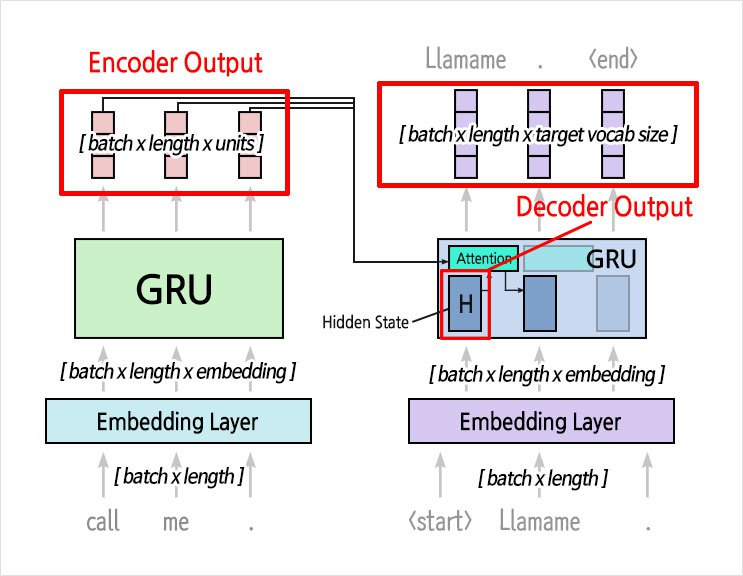

In [ ]:
Image(filename='/content/drive/MyDrive/lms/seq2seq_translation/gru_structure.jpg') 

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, dropout):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True, dropout=dropout)
        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

Encoder는 모든 Time-Step의 Hidden State를 출력으로 갖는다.
<br/>일반적으로 Encoder의 Final State를 Hidden State로 사용한다.

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, dropout):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units, return_sequences=True,
                                       return_state=True, dropout=dropout)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

Decoder는 Encoder의 출력과 Decoder의 t-1 Step의 Hidden State로 Attention을 취하여 t Step의 Hidden State를 만든다.
<br/>Decoder에서 t Step의 단어로 예측된 것을 실제 정답과 대조해 Loss를 계산한다.
<br/>생성된 t Step의 Hidden State는 t+1 Step의 Hidden State를 만들기 위해 다시 Decoder에 전달된다.

In [ ]:
batch_size     = 64
src_vocab_size = len(enc_tokenizer.index_word) + 1
tgt_vocab_size = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512
dropout = 0.2

encoder = Encoder(src_vocab_size, embedding_dim, units, dropout)
decoder = Decoder(tgt_vocab_size, embedding_dim, units, dropout)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((batch_size, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output :', sample_output.shape)

sample_state = tf.random.uniform((batch_size, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((batch_size, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State :', h_dec.shape)
print ('Attention :', attn.shape)

Encoder Output : (64, 30, 1024)
Decoder Output: (64, 30387)
Decoder Hidden State : (64, 1024)
Attention : (64, 30, 1)


Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰 주도록 한다.

##Optimizer & Loss

Seq2seq with Attention에서 model.fit()은 따로 존재하지 않는다.
<br/>Encoder-Decoder 구조의 경우 입출력이 단순하지 않아 학습 과정을 직접 정의한다.

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

 Encoder-Decoder 구조는 학습 과정이 일반적이지 않으므로 직접 Loss를 커스텀해서 사용한다.
 <br/>SparseCategoricalCrossentropy()는 모델이 출력한 확률 분포와 (One-hot이 아닌) 정수 인덱스 답안을 비교해 Cross Entropy값을 구한다.
<br/>from_logits는 확률 분포가 Softmax를 거쳐서 들어오는지 모델의 출력값 그대로 들어오는지를 결정 (True/False) 한다.
<br/>패딩에 대한 처리를 해주지 않으면 < PAD > 토큰만을 생성할 확률이 높아지기 때문에 이 문제를 방지하기 위해 mask 가 사용된다.
<br/>mask는 정답지에서 < PAD > 토큰을 찾아내어 그 부분에 대한 Loss는 구하지 않도록 하는 역할을 한다.
<br/>equal()는 정확히는 0 이 아닌 < PAD > 토큰의 인덱스를 전달하는 것이 맞지만 대부분의 경우는 0으로 패딩되기 때문에 편의상 0을 전달하여 처리한다.

##Train Step

In [ ]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

@tf.function 데코레이터는 훈련 외적인 텐서플로우 연산을 GPU에서 동작하게 해 훈련을 가속한다.
<br/>tf.GradientTape()는 학습하며 발생한 모든 연산을 기록하는 테이프이다. 모델이 각 스텝의 최종 단계에서 미분값을 구하는 데에 사용된다.

train_step()의 학습 과정
<br/>1) Encoder에 소스 문장을 전달해 컨텍스트 벡터인 enc_out 을 생성
<br/>2) t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의&emsp;|&emsp;h_dec = enc_out[:, -1]
<br/>3) Decoder에 입력으로 전달할 < start > 토큰 문장 생성
<br/>4) < start > 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측&emsp;|&emsp; pred
<br/>5) 예측된 단어와 정답 간의 Loss를 구한 후, t=1의 정답 단어를 다음 입력으로 사용 (예측 단어 X)

##Evaluation

In [ ]:
def preprocess_sentence(sentence):

    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^가-힣a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()

    return sentence

In [ ]:
def evaluate(sentence, encoder, decoder):

    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    sentence = preprocess_sentence(sentence)

    mecab = Mecab()
    inputs = enc_tokenizer.texts_to_sequences([mecab.morphs(sentence)])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input : %s' % (sentence))
    print('Predicted translation : {}'.format(result))
    print()

    mecab = Mecab()
    attention = attention[:len(result.split()), :len(mecab.morphs(sentence))]
    plot_attention(attention, mecab.morphs(sentence), result.split(' '))

In [ ]:
def sentence_translator(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input : %s' % (sentence))
    print('Predicted translation : {}'.format(result))

#모델 학습

##Hyperparameter

In [ ]:
CSS = """.output {flex-direction: row;}"""
HTML('<style>{}</style>'.format(CSS))

hyperparameter_tuning = pd.DataFrame({'Batch Size':[64, 32, 128, 64], 'Units':[1024, 256, 128, 128], 
                             'Embedding Dimension':[512, 64, 128, 64], 'Dropout Rate':[0.2, 0.2, 0.2, 0.2],
                             'Sequence Length':[30, 30, 30, 30]}, index=['Model 1', 'Model 2', 'Model 3', 'Model 4'])

embedding_hidden_size = pd.DataFrame({'Encoder Output':['(64, 30, 1024)', '(32, 30, 256)', '(128, 30, 128)', '(64, 30, 128)'],
                   'Decoder Output':['(64, 30387)', '(32, 30387)', '(128, 30387)', '(64, 30387)'],
                   'Decoder Hidden State':['(64, 1024)', '(32, 256)', '(128, 128)', '(64, 128)'],
                   'Attention':['(64, 30, 1)', '(32, 30, 1)', '(128, 30, 1)', '(64, 30, 1)']},
                    index=['Model 1', 'Model 2', 'Model 3', 'Model 4'])

reorderlist = ['Activation Function', 'Optimizer', 'Loss Function']
training_way = pd.DataFrame({'Model':{'Activation Function':'Softmax', 'Optimizer':'Adam',
                                            'Loss Function': 'Sparse Categorical Crossentropy'}})
training_way = training_way.iloc[pd.Categorical(training_way.index,reorderlist).argsort()]

display(hyperparameter_tuning)
print("\n")
display(embedding_hidden_size)
print("\n")
display(training_way)

,Batch Size,Units,Embedding Dimension,Dropout Rate,Sequence Length
Model 1,64,1024,512,0.2,30
Model 2,32,256,64,0.2,30
Model 3,128,128,128,0.2,30
Model 4,64,128,64,0.2,30


,Encoder Output,Decoder Output,Decoder Hidden State,Attention
Model 1,"(64, 30, 1024)","(64, 30387)","(64, 1024)","(64, 30, 1)"
Model 2,"(32, 30, 256)","(32, 30387)","(32, 256)","(32, 30, 1)"
Model 3,"(128, 30, 128)","(128, 30387)","(128, 128)","(128, 30, 1)"
Model 4,"(64, 30, 128)","(64, 30387)","(64, 128)","(64, 30, 1)"


,Model
Activation Function,Softmax
Optimizer,Adam
Loss Function,Sparse Categorical Crossentropy


##Model Initialization

하이퍼파라미터 튜닝을 하여 새로운 모델을 구성하고 다시 학습할 때
Google Colab의 런타임을 다시 시작해야 한다.
<br/>런타임 재시작할 때마다 처음부터 코드를 작동시켜야하는 번거로움을 느낀다.
<br/>모델 초기화 함수 코드가 있었다면 런타임을 재시작하지 않아도 되었을 것이다.
<br/>모델 초기화 함수의 필요성을 느낀다.

##First Model

In [ ]:
batch_size     = 64
src_vocab_size = len(enc_tokenizer.index_word) + 1
tgt_vocab_size = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512
dropout = 0.2

encoder = Encoder(src_vocab_size, embedding_dim, units, dropout)
decoder = Decoder(tgt_vocab_size, embedding_dim, units, dropout)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((batch_size, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output :', sample_output.shape)

sample_state = tf.random.uniform((batch_size, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((batch_size, 1)),
                                     sample_state, sample_output)

print ('Decoder Output :', sample_logits.shape)
print ('Decoder Hidden State :', h_dec.shape)
print ('Attention :', attn.shape)

Encoder Output : (64, 30, 1024)
Decoder Output : (64, 30387)
Decoder Hidden State : (64, 1024)
Attention : (64, 30, 1)


In [ ]:
first_model_loss_df = pd.DataFrame({'Epoch':[0], 'Loss':[0]})

epochs = 10
count = 0

for epoch in range(epochs):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], batch_size))
    random.shuffle(idx_list)
    t = tqdm(idx_list)   

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx + batch_size],
                                dec_tensor[idx:idx +  batch_size],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss

        count += 1
        
        if count % len(idx_list) == 0:
            first_model_loss_df.loc[epoch] = [epoch + 1, round(total_loss.numpy() / (batch + 1), 4)]
            first_model_loss_df = first_model_loss_df.astype({'Epoch':'int'})

        t.set_description_str('Epoch %2d' % (epoch + 1))    
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))          

Epoch 10: 100%|██████████| 469/469 [02:55<00:00,  2.68it/s, Loss 4.5642]


EPOCHS = 10 만큼 반복하는 루프에 진입한 후 각 배치의 시작 인덱스를 idx_list 배열에 저장한다.
<br/>모델이 학습을 원활하게 할 수 있도록 인덱스를 섞어서 데이터를 처리한다.
<br/>각 미니배치를 train_step()에서 학습하고  Loss를 계산한다.


In [ ]:
pd.set_option('display.max_rows', 4)
first_model_loss_df

,Epoch,Loss
0,1,4.6990
1,2,4.5603
...,...,...
8,9,4.5649
9,10,4.5642


In [ ]:
first_model_loss_df.to_csv("/content/drive/MyDrive/lms/seq2seq_translation/first_model_loss.csv", index = False)

##Second Model

In [ ]:
batch_size     = 32
src_vocab_size = len(enc_tokenizer.index_word) + 1
tgt_vocab_size = len(dec_tokenizer.index_word) + 1

units         = 256
embedding_dim = 64
dropout = 0.2

encoder = Encoder(src_vocab_size, embedding_dim, units, dropout)
decoder = Decoder(tgt_vocab_size, embedding_dim, units, dropout)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((batch_size, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output :', sample_output.shape)

sample_state = tf.random.uniform((batch_size, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((batch_size, 1)),
                                     sample_state, sample_output)

print ('Decoder Output :', sample_logits.shape)
print ('Decoder Hidden State :', h_dec.shape)
print ('Attention :', attn.shape)

Encoder Output : (32, 30, 256)
Decoder Output : (32, 30387)
Decoder Hidden State : (32, 256)
Attention : (32, 30, 1)


In [ ]:
second_model_loss_df = pd.DataFrame({'Epoch':[0], 'Loss':[0]})

epochs = 10
count = 0

for epoch in range(epochs):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], batch_size))
    random.shuffle(idx_list)
    t = tqdm(idx_list)   

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx + batch_size],
                                dec_tensor[idx:idx +  batch_size],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss

        count += 1
        
        if count % len(idx_list) == 0:
            second_model_loss_df.loc[epoch] = [epoch + 1, round(total_loss.numpy() / (batch + 1), 4)]
            second_model_loss_df = second_model_loss_df.astype({'Epoch':'int'})
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))   

Epoch 10: 100%|██████████| 938/938 [01:36<00:00,  9.77it/s, Loss 4.4448]


In [ ]:
pd.set_option('display.max_rows', 4)
second_model_loss_df

,Epoch,Loss
0,1,4.5586
1,2,4.4829
...,...,...
8,9,4.4421
9,10,4.4448


In [ ]:
second_model_loss_df.to_csv("/content/drive/MyDrive/lms/seq2seq_translation/second_model_loss.csv", index = False)

##Third Model

In [ ]:
batch_size     = 128
src_vocab_size = len(enc_tokenizer.index_word) + 1
tgt_vocab_size = len(dec_tokenizer.index_word) + 1

units         = 128
embedding_dim = 128
dropout = 0.2

encoder = Encoder(src_vocab_size, embedding_dim, units, dropout)
decoder = Decoder(tgt_vocab_size, embedding_dim, units, dropout)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((batch_size, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output :', sample_output.shape)

sample_state = tf.random.uniform((batch_size, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((batch_size, 1)),
                                     sample_state, sample_output)

print ('Decoder Output :', sample_logits.shape)
print ('Decoder Hidden State :', h_dec.shape)
print ('Attention :', attn.shape)

Encoder Output : (128, 30, 128)
Decoder Output : (128, 30387)
Decoder Hidden State : (128, 128)
Attention : (128, 30, 1)


In [ ]:
third_model_loss_df = pd.DataFrame({'Epoch':[0], 'Loss':[0]})

epochs = 10
count = 0

for epoch in range(epochs):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], batch_size))
    random.shuffle(idx_list)
    t = tqdm(idx_list)   

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx + batch_size],
                                dec_tensor[idx:idx +  batch_size],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss

        count += 1
        
        if count % len(idx_list) == 0:
            third_model_loss_df.loc[epoch] = [epoch + 1, round(total_loss.numpy() / (batch + 1), 4)]
            third_model_loss_df = third_model_loss_df.astype({'Epoch':'int'})

        t.set_description_str('Epoch %2d' % (epoch + 1))    
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))   

Epoch 10: 100%|██████████| 235/235 [00:29<00:00,  7.91it/s, Loss 4.3875]


In [ ]:
pd.set_option('display.max_rows', 4)
third_model_loss_df

,Epoch,Loss
0,1,4.5931
1,2,4.3884
...,...,...
8,9,4.3873
9,10,4.3875


In [ ]:
third_model_loss_df.to_csv("/content/drive/MyDrive/lms/seq2seq_translation/third_model_loss.csv", index = False)

##Fourth Model

In [ ]:
batch_size     = 64
src_vocab_size = len(enc_tokenizer.index_word) + 1
tgt_vocab_size = len(dec_tokenizer.index_word) + 1

units         = 128
embedding_dim = 64
dropout = 0.2

encoder = Encoder(src_vocab_size, embedding_dim, units, dropout)
decoder = Decoder(tgt_vocab_size, embedding_dim, units, dropout)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((batch_size, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output :', sample_output.shape)

sample_state = tf.random.uniform((batch_size, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((batch_size, 1)),
                                     sample_state, sample_output)

print ('Decoder Output :', sample_logits.shape)
print ('Decoder Hidden State :', h_dec.shape)
print ('Attention :', attn.shape)

Encoder Output : (64, 30, 128)
Decoder Output : (64, 30387)
Decoder Hidden State : (64, 128)
Attention : (64, 30, 1)


In [ ]:
fourth_model_loss_df = pd.DataFrame({'Epoch':[0], 'Loss':[0]})

epochs = 10
count = 0

for epoch in range(epochs):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], batch_size))
    random.shuffle(idx_list)
    t = tqdm(idx_list)   

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx + batch_size],
                                dec_tensor[idx:idx +  batch_size],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss

        count += 1
        
        if count % len(idx_list) == 0:
            fourth_model_loss_df.loc[epoch] = [epoch + 1, round(total_loss.numpy() / (batch + 1), 4)]
            fourth_model_loss_df = fourth_model_loss_df.astype({'Epoch':'int'})
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))  

Epoch 10: 100%|██████████| 469/469 [00:44<00:00, 10.54it/s, Loss 3.6855]


In [ ]:
pd.set_option('display.max_rows', 4)
fourth_model_loss_df

,Epoch,Loss
0,1,4.5274
1,2,4.4040
...,...,...
8,9,3.8107
9,10,3.6855


In [ ]:
fourth_model_loss_df.to_csv("/content/drive/MyDrive/lms/seq2seq_translation/fourth_model_loss.csv", index = False)

##Model Selection

In [ ]:
first_loss = pd.read_csv("/content/drive/MyDrive/lms/seq2seq_translation/first_model_loss.csv").iloc[-1]['Loss']
second_loss = pd.read_csv("/content/drive/MyDrive/lms/seq2seq_translation/second_model_loss.csv").iloc[-1]['Loss']
third_loss = pd.read_csv("/content/drive/MyDrive/lms/seq2seq_translation/third_model_loss.csv").iloc[-1]['Loss']
fourth_loss = pd.read_csv("/content/drive/MyDrive/lms/seq2seq_translation/fourth_model_loss.csv").iloc[-1]['Loss']

hyperparameter_tuning_result = pd.DataFrame({'Batch Size':[64, 32, 128, 64],
                             'Units':[1024, 256, 128, 128], 
                             'Embedding Dimension':[512, 64, 128, 64],
                             'Epoch':[10, 10, 10, 10],
                             'Loss':[first_loss, second_loss, third_loss, fourth_loss]},
                             index=['Model 1', 'Model 2', 'Model 3', 'Model 4'])

hyperparameter_tuning_result.sort_values(by='Loss', ascending=True)

,Batch Size,Units,Embedding Dimension,Epoch,Loss
Model 4,64,128,64,10,3.6855
Model 3,128,128,128,10,4.3875
Model 2,32,256,64,10,4.4448
Model 1,64,1024,512,10,4.5642


#최종 모델

##Epoch Test

In [ ]:
enc_corpus = []
dec_corpus = []

for ko_sen in ko_unique:
  enc_corpus.append(ko_preprocess_sentence(ko_sen))

for en_sen in en_unique:
  dec_corpus.append(en_preprocess_sentence(en_sen, s_token=True, e_token=True))

In [ ]:
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

In [ ]:
enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

데이터를 훈련 데이터와 검증 데이터로 분리한다.

In [ ]:
print("Korean Vocab Size :", len(enc_tokenizer.index_word))
print("English Vocab Size :", len(dec_tokenizer.index_word))

Korean Vocab Size : 49786
English Vocab Size : 44460


In [ ]:
batch_size     = 64
src_vocab_size = len(enc_tokenizer.index_word) + 1
tgt_vocab_size = len(dec_tokenizer.index_word) + 1

units         = 128
embedding_dim = 64
dropout = 0.2

encoder = Encoder(src_vocab_size, embedding_dim, units, dropout)
decoder = Decoder(tgt_vocab_size, embedding_dim, units, dropout)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((batch_size, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output :', sample_output.shape)

sample_state = tf.random.uniform((batch_size, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((batch_size, 1)),
                                     sample_state, sample_output)

print ('Decoder Output :', sample_logits.shape)
print ('Decoder Hidden State :', h_dec.shape)
print ('Attention :', attn.shape)

Encoder Output : (64, 30, 128)
Decoder Output : (64, 44461)
Decoder Hidden State : (64, 128)
Attention : (64, 30, 1)


In [ ]:
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss

훈련 데이터와 검증 데이터를 사용하는 eval_step()을 정의한다.

In [ ]:
model_loss_df = pd.DataFrame({'Epoch':[0], 'Train Loss':[0], 'Test Loss':[0]})

epochs = 50
train_count = 0
test_count = 0

sentence_list = ["오바마는 대통령이다.", "시민들은 도시 속에 산다.",
                 "커피는 필요 없다.", "일곱 명의 사망자가 발생했다."]
                 

for epoch in range(epochs):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], batch_size))
    random.shuffle(idx_list)

    for (batch, idx) in enumerate(idx_list):
        batch_loss = train_step(enc_train[idx:idx + batch_size],
                                dec_train[idx:idx + batch_size],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss

        train_count += 1

        if train_count % len(idx_list) == 0:
            model_loss_df.loc[epoch] = [epoch + 1, round(total_loss.numpy() / (batch + 1), 4), 0]
            model_loss_df = model_loss_df.astype({'Epoch':'int'})

            if epoch == 0 or ((epoch + 1) % 5 == 0 and epoch + 1 <= 30) or ((epoch + 1) % 2 == 0 and (epoch + 1) > 30):
                print('Epoch {}'.format(epoch + 1))
                print('Train Loss {:.4f}'.format(total_loss.numpy() / (batch + 1)), end="  ")

    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], batch_size))
    random.shuffle(idx_list)

    for (test_batch, idx) in enumerate(idx_list):
        test_batch_loss = eval_step(enc_val[idx:idx + batch_size],
                                    dec_val[idx:idx + batch_size],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        test_count += 1
        
        if test_count % len(idx_list) == 0:
            model_loss_df.loc[epoch, 'Test Loss'] = [round(test_loss.numpy() / (test_batch + 1), 4)]

            if epoch == 0 or ((epoch + 1) % 5 == 0 and epoch + 1 <= 30) or ((epoch + 1) % 2 == 0 and (epoch + 1) > 30):
                print('Test Loss {:.4f}'.format(test_loss.numpy() / (test_batch + 1)))
                print()

                for sentence in sentence_list:
                  sentence_translator(sentence, encoder, decoder)
                  print()
                print()

Epoch 1
Train Loss 4.4504  Test Loss 4.4120

Input : 오바마는 대통령이다 .
Predicted translation : the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 

Input : 시민들은 도시 속에 산다 .
Predicted translation : the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 

Input : 커피는 필요 없다 .
Predicted translation : the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 

Input : 일곱 명의 사망자가 발생했다 .
Predicted translation : the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


Epoch 5
Train Loss 3.9160  Test Loss 3.8064

Input : 오바마는 대통령이다 .
Predicted translation : the u . s . <end> 

Input : 시

,Epoch,Train Loss,Test Loss
0,1,4.4504,4.4120
9,10,3.1338,3.3744
19,20,2.4977,3.4098
29,30,2.1653,3.6602
39,40,1.9546,3.8965
49,50,1.8062,4.1101


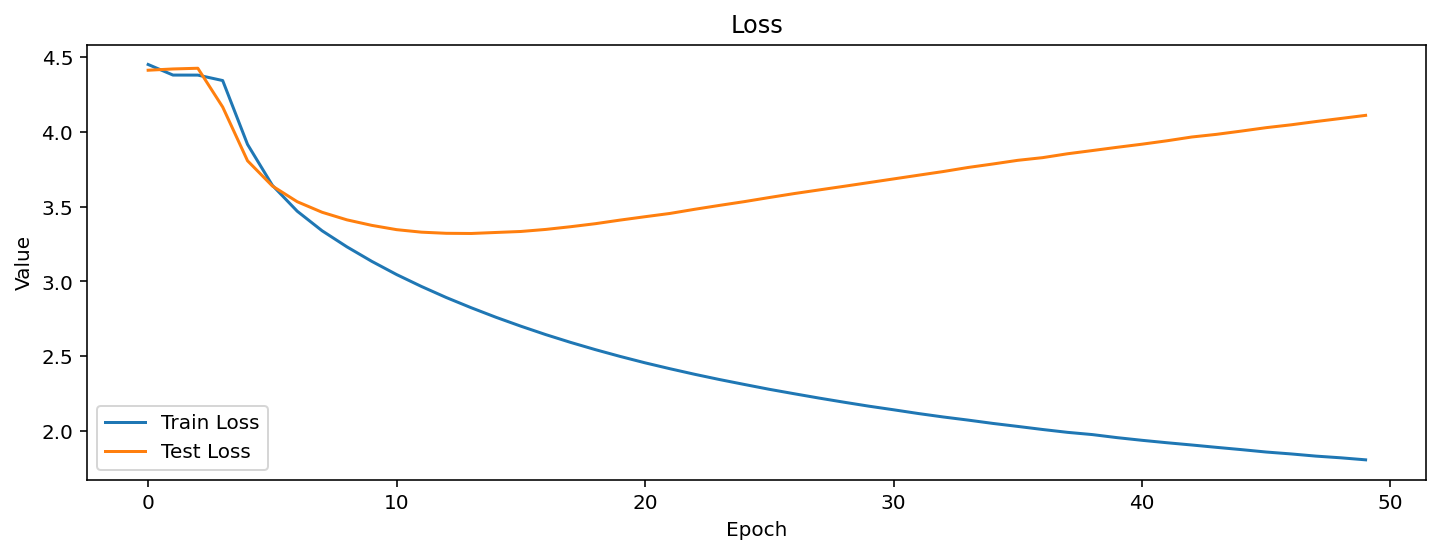

In [ ]:
CSS = """.output {flex-direction: row;}"""
HTML('<style>{}</style>'.format(CSS))

with pd.option_context('display.max_rows',None):
  display(model_loss_df[(model_loss_df.Epoch == 1) | (model_loss_df.Epoch % 10 == 0)])
print("\n")

plt.figure(figsize=[12, 4])
plt.plot(model_loss_df['Train Loss'] , label="Train Loss")
plt.plot(model_loss_df['Test Loss'], label="Test Loss")
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()

In [ ]:
model_loss_df.to_csv("/content/drive/MyDrive/lms/seq2seq_translation/model_loss.csv", index = False)

최종 모델의 Epoch을 40으로 설정한다.
<br/>Epoch 40 이상부터는 Train Loss의 변화가 거의 없고 Test Loss가 증가하여 과적합 문제가 심해진다.

##Model Evaluation

In [ ]:
final_model_loss_df = pd.DataFrame({'Epoch':[0], 'Train Loss':[0], 'Test Loss':[0]})

epochs = 40
train_count = 0
test_count = 0  

for epoch in range(epochs):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], batch_size))
    random.shuffle(idx_list)

    for (batch, idx) in enumerate(idx_list):
        batch_loss = train_step(enc_train[idx:idx + batch_size],
                                dec_train[idx:idx + batch_size],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss

        train_count += 1

        if train_count % len(idx_list) == 0:
            final_model_loss_df.loc[epoch] = [epoch + 1, round(total_loss.numpy() / (batch + 1), 4), 0]
            final_model_loss_df = final_model_loss_df.astype({'Epoch':'int'})

            if epoch == 0 or (epoch + 1) % 10 == 0:
                print('Epoch {}  Train Loss {:.4f}'.format(epoch + 1, total_loss.numpy() / (batch + 1)), end="  ")

    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], batch_size))
    random.shuffle(idx_list)

    for (test_batch, idx) in enumerate(idx_list):
        test_batch_loss = eval_step(enc_val[idx:idx + batch_size],
                                    dec_val[idx:idx + batch_size],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        test_count += 1
        
        if test_count % len(idx_list) == 0:
            final_model_loss_df.loc[epoch, 'Test Loss'] = [round(test_loss.numpy() / (test_batch + 1), 4)]

            if epoch == 0 or (epoch + 1) % 10 == 0:
                print('Test Loss {:.4f}'.format(test_loss.numpy() / (test_batch + 1)))

Epoch 1  Train Loss 4.4557  Test Loss 4.3959
Epoch 10  Train Loss 3.1322  Test Loss 3.3625
Epoch 20  Train Loss 2.5257  Test Loss 3.4187
Epoch 30  Train Loss 2.2004  Test Loss 3.6839
Epoch 40  Train Loss 1.9897  Test Loss 3.9271


,Epoch,Train Loss,Test Loss
0,1,4.4557,4.3959
1,2,4.3832,4.4076
...,...,...,...
38,39,2.0059,3.9049
39,40,1.9897,3.9271


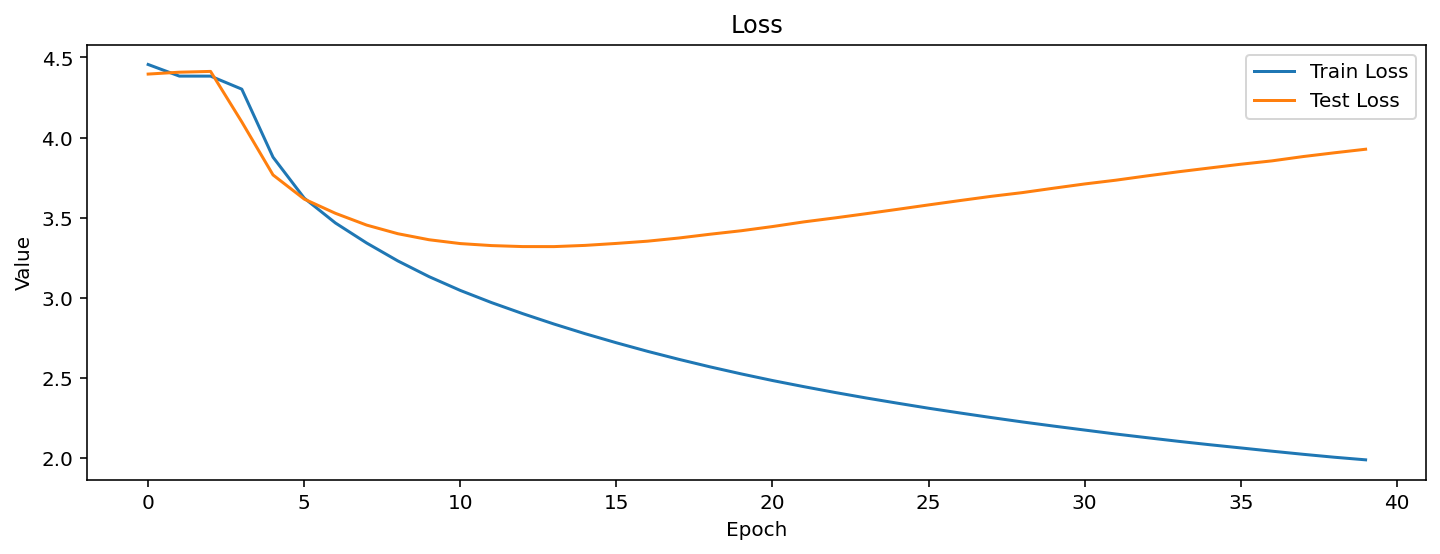

In [ ]:
CSS = """.output {flex-direction: row;}"""
HTML('<style>{}</style>'.format(CSS))

pd.set_option('display.max_rows', 4)
display(final_model_loss_df)
print("\n")

plt.figure(figsize=[12, 4])
plt.plot(final_model_loss_df['Train Loss'] , label="Train Loss")
plt.plot(final_model_loss_df['Test Loss'], label="Test Loss")
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()

In [ ]:
final_model_loss_df.to_csv("/content/drive/MyDrive/lms/seq2seq_translation/final_model_loss.csv", index = False)

In [ ]:
sentence_list = ["오바마는 대통령이다.", "시민들은 도시 속에 산다.",
                 "커피는 필요 없다.", "일곱 명의 사망자가 발생했다."]

for sentence in sentence_list:
  sentence_translator(sentence, encoder, decoder)
  print()

Input : 오바마는 대통령이다 .
Predicted translation : obama is a democrat . <end> 

Input : 시민들은 도시 속에 산다 .
Predicted translation : they are still searching for the city of people , as many people , as many people , as many people , as many people , as many people , as many people , as many people , as many 

Input : 커피는 필요 없다 .
Predicted translation : it is a little bit of the way <end> 

Input : 일곱 명의 사망자가 발생했다 .
Predicted translation : two people were killed . <end> 



Input : 오바마는 대통령이다 .
Predicted translation : obama is a democrat . <end> 



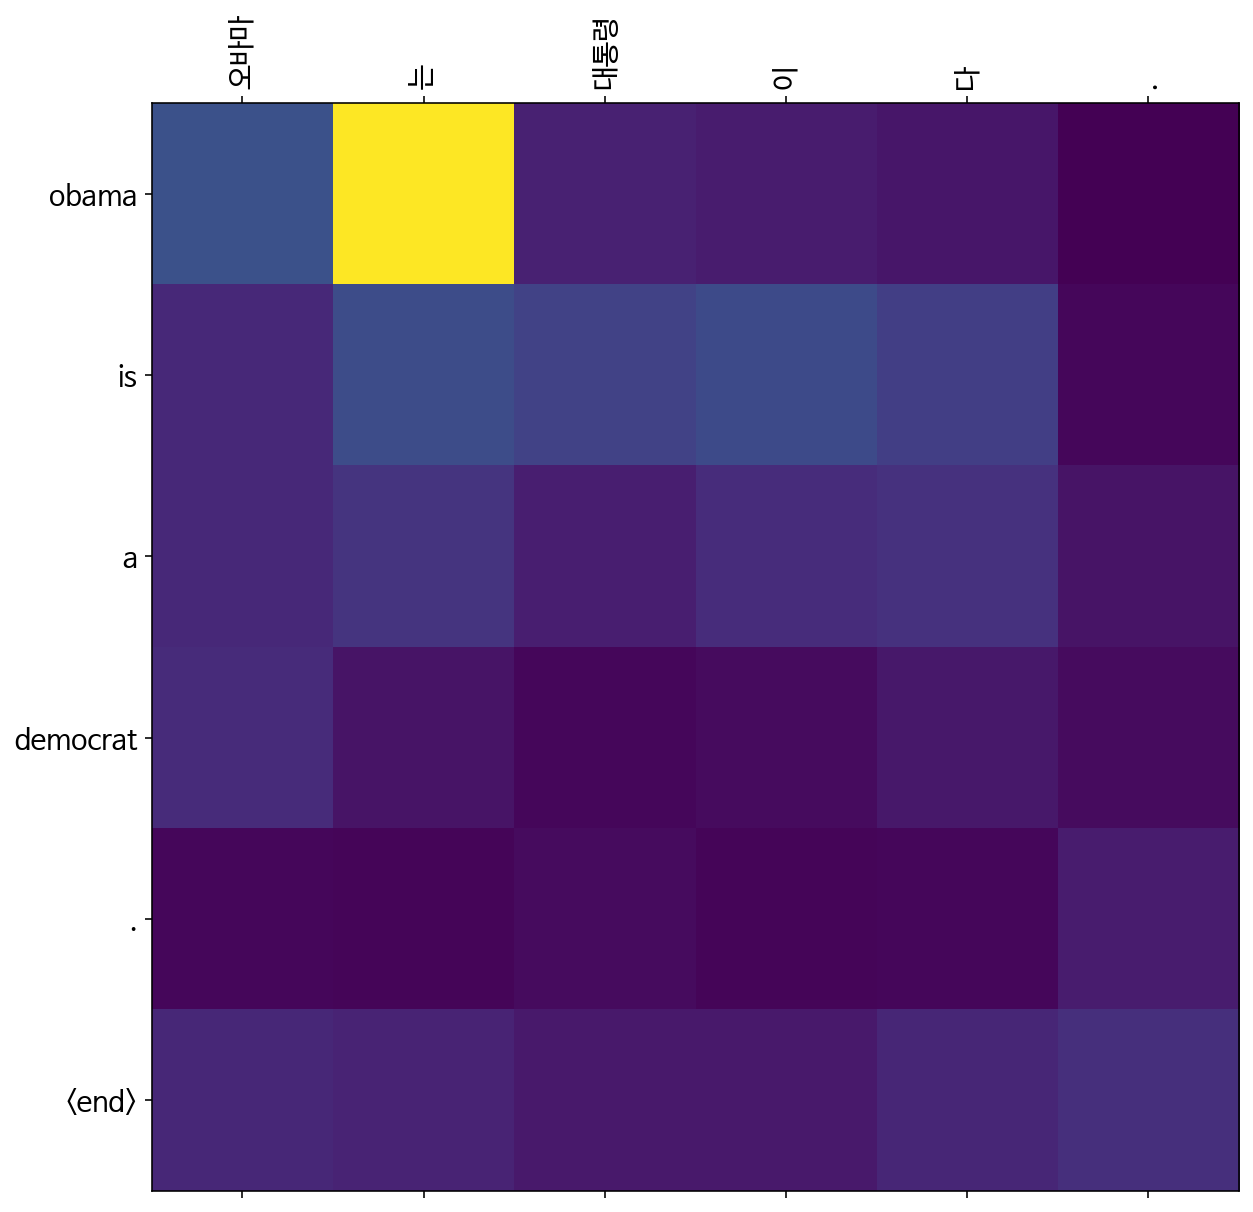

In [ ]:
translate("오바마는 대통령이다.", encoder, decoder)

Input : 시민들은 도시 속에 산다 .
Predicted translation : they are still searching for the city of people , as many people , as many people , as many people , as many people , as many people , as many people , as many people , as many 



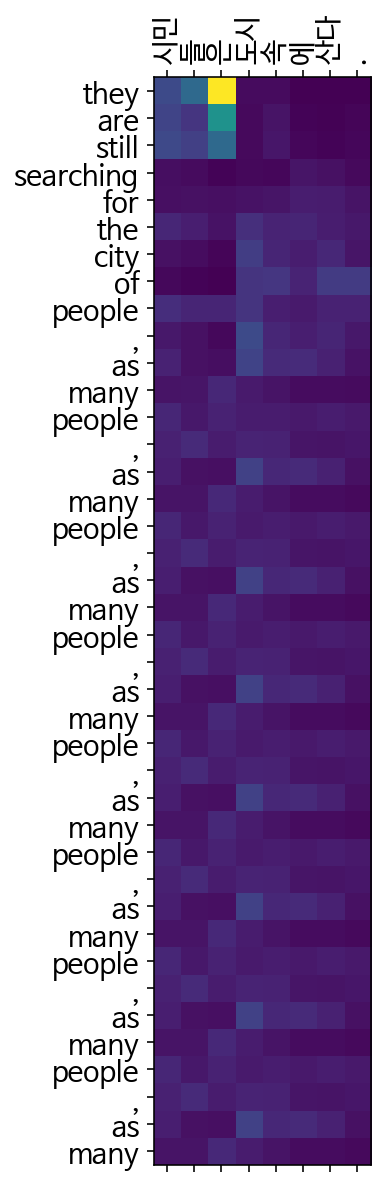

In [ ]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input : 커피는 필요 없다 .
Predicted translation : it is a little bit of the way <end> 



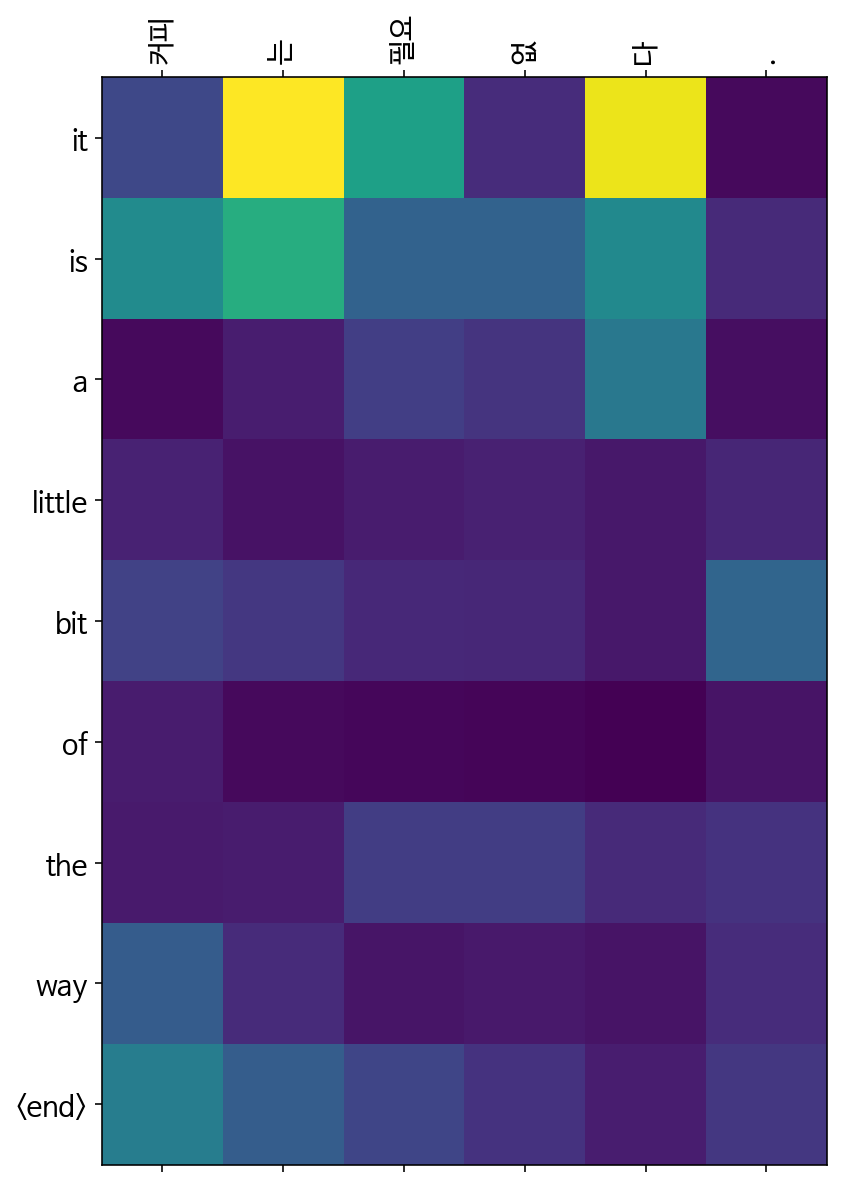

In [ ]:
translate("커피는 필요 없다.", encoder, decoder)

Input : 일곱 명의 사망자가 발생했다 .
Predicted translation : two people were killed . <end> 



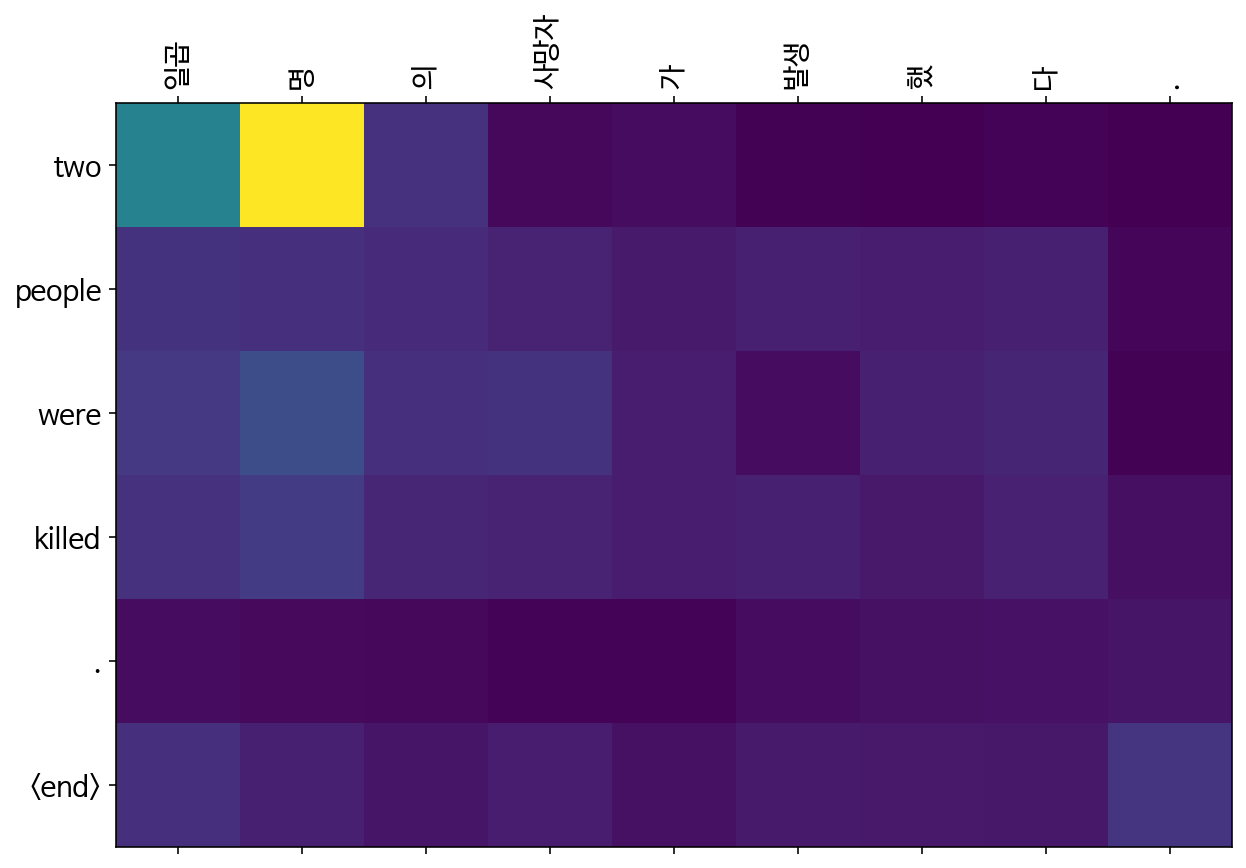

In [ ]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

##Random State

동일한 하이퍼파라미터와 데이터를 사용했는데  알고리즘을 작동시킬 때마다 다른 모델 학습 결과가 나온다.
<br/>딥러닝 모델은 Random State로 작동하는 것인가?
<br/>그렇다면 Random State로 작동하는 딥러닝 모델의 성능을 어떻게 측정할 수 있는가?
<br/>매번 달라지는 모델 성능을 어떻게 확률분포로 나타낼 수 있는가?

In [ ]:
final_model_loss_df2 = pd.DataFrame({'Epoch':[0], 'Train Loss':[0], 'Test Loss':[0]})

epochs = 40
train_count = 0
test_count = 0

sentence_list = ["오바마는 대통령이다.", "시민들은 도시 속에 산다.",
                 "커피는 필요 없다.", "일곱 명의 사망자가 발생했다."]
                 

for epoch in range(epochs):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], batch_size))
    random.shuffle(idx_list)

    for (batch, idx) in enumerate(idx_list):
        batch_loss = train_step(enc_train[idx:idx + batch_size],
                                dec_train[idx:idx + batch_size],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss

        train_count += 1

        if train_count % len(idx_list) == 0:
            final_model_loss_df2.loc[epoch] = [int(epoch + 1), round(total_loss.numpy() / (batch + 1), 4), 0]
            final_model_loss_df2 = final_model_loss_df2.astype({'Epoch':'int'})

            if epoch == 0 or (epoch + 1) % 10 == 0:
                print('Epoch {}  Train Loss {:.4f}'.format(epoch + 1, total_loss.numpy() / (batch + 1)), end="  ")

    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], batch_size))
    random.shuffle(idx_list)

    for (test_batch, idx) in enumerate(idx_list):
        test_batch_loss = eval_step(enc_val[idx:idx + batch_size],
                                    dec_val[idx:idx + batch_size],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        test_count += 1
        
        if test_count % len(idx_list) == 0:
            final_model_loss_df2.loc[epoch, 'Test Loss'] = [round(test_loss.numpy() / (test_batch + 1), 4)]
            final_model_loss_df2 = final_model_loss_df2.astype({'Epoch':'int'})

            if epoch == 0 or (epoch + 1) % 10 == 0:
                print('Test Loss {:.4f}'.format(test_loss.numpy() / (test_batch + 1)))

Epoch 1  Train Loss 4.4549  Test Loss 4.3975
Epoch 10  Train Loss 3.1367  Test Loss 3.3661
Epoch 20  Train Loss 2.5112  Test Loss 3.4173
Epoch 30  Train Loss 2.1837  Test Loss 3.6765
Epoch 40  Train Loss 1.9727  Test Loss 3.9215


,Epoch,Train Loss,Test Loss
0,1,4.4549,4.3975
1,2,4.3833,4.4080
...,...,...,...
38,39,1.9897,3.9019
39,40,1.9727,3.9215


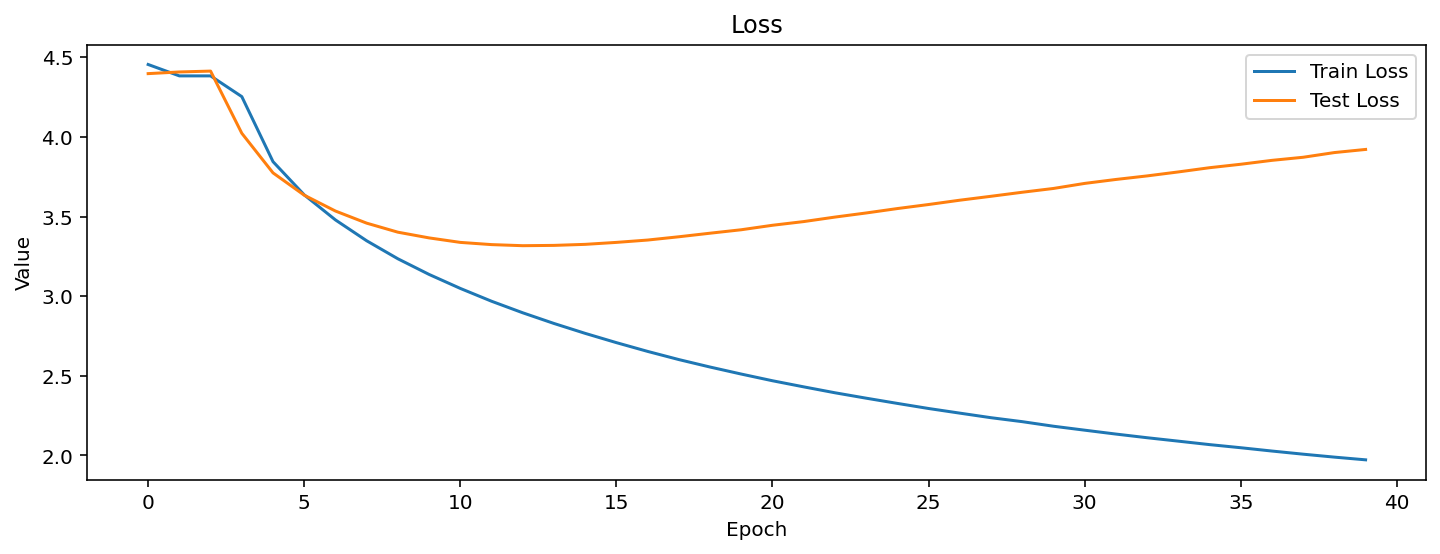

In [ ]:
CSS = """.output {flex-direction: row;}"""
HTML('<style>{}</style>'.format(CSS))

pd.set_option('display.max_rows', 4)
display(final_model_loss_df2)
print("\n")

plt.figure(figsize=[12, 4])
plt.plot(final_model_loss_df2['Train Loss'] , label="Train Loss")
plt.plot(final_model_loss_df2['Test Loss'], label="Test Loss")
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()

In [ ]:
final_model_loss_df2.to_csv("/content/drive/MyDrive/lms/seq2seq_translation/final_model_loss2.csv", index = False)

In [ ]:
sentence_list = ["오바마는 대통령이다.", "시민들은 도시 속에 산다.",
                 "커피는 필요 없다.", "일곱 명의 사망자가 발생했다."]

for sentence in sentence_list:
  sentence_translator(sentence, encoder, decoder)
  print()

Input : 오바마는 대통령이다 .
Predicted translation : obama says he was a key presidential nomination . <end> 

Input : 시민들은 도시 속에 산다 .
Predicted translation : the survey showed fires that the city , square miles , and some of the city of upstate new orleans . <end> 

Input : 커피는 필요 없다 .
Predicted translation : the t know , you know that you get to be pretty good . <end> 

Input : 일곱 명의 사망자가 발생했다 .
Predicted translation : the two were killed . <end> 



#결론

**하이퍼파라미터**

In [ ]:
CSS = """.output {flex-direction: row;}"""
HTML('<style>{}</style>'.format(CSS))

final_hyperparameter = pd.DataFrame({'Batch Size':[64], 'Units':[128], 'Embedding Dimension':[64],
                                     'Dropout Rate':[0.2], 'Sequence Length':[30]}, index=['Final Model'])

final_embedding_hidden_size = pd.DataFrame({'Encoder Output':['(64, 30, 128)'], 'Decoder Output':['(64, 44461)'],
                   'Decoder Hidden State':['(64, 128)'], 'Attention':['(64, 30, 1)']}, index=['Final Model'])

reorderlist = ['Tokenizer', 'Korean Vocab Size', 'English Vocab Size', 'Text Max Length',
               'Activation Function', 'Optimizer', 'Loss Function', 'Epoch']
learning_way = pd.DataFrame({'Final Model':{'Tokenizer': 'MeCab. Split', 
                            'Korean Vocab Size': 49786, 'English Vocab Size': 44460, 'Text Max Length': 40, 
                            'Activation Function':'Softmax', 'Optimizer':'Adam',
                            'Loss Function': 'Sparse Categorical Crossentropy', 'Epoch':40}})
learning_way = learning_way.iloc[pd.Categorical(learning_way.index,reorderlist).argsort()]

final_model_loss_df = pd.read_csv("/content/drive/MyDrive/lms/seq2seq_translation/final_model_loss.csv")

display(final_hyperparameter)
print("\n")
display(final_embedding_hidden_size)
print("\n")
with pd.option_context('display.max_rows',None):
  display(learning_way)
print("\n")
with pd.option_context('display.max_rows',None):
  display(final_model_loss_df[(final_model_loss_df.Epoch == 1) | (final_model_loss_df.Epoch % 10 == 0)])

,Batch Size,Units,Embedding Dimension,Dropout Rate,Sequence Length
Final Model,64,128,64,0.2,30


,Encoder Output,Decoder Output,Decoder Hidden State,Attention
Final Model,"(64, 30, 128)","(64, 44461)","(64, 128)","(64, 30, 1)"


,Final Model
Tokenizer,MeCab. Split
Korean Vocab Size,49786
English Vocab Size,44460
Text Max Length,40
Activation Function,Softmax
Optimizer,Adam
Loss Function,Sparse Categorical Crossentropy
Epoch,40


,Epoch,Train Loss,Test Loss
0,1,4.4557,4.3959
9,10,3.1322,3.3625
19,20,2.5257,3.4187
29,30,2.2004,3.6839
39,40,1.9897,3.9271


**Random State**

동일한 하이퍼파라미터와 데이터를 사용했는데 알고리즘을 작동시킬 때마다 다른 모델 학습 결과가 나온다.
<br/>딥러닝 모델은 Random State로 작동하는 것인가?
<br/>그렇다면 Random State로 작동하는 딥러닝 모델의 성능을 어떻게 측정할 수 있는가?
<br/>매번 달라지는 모델 성능을 어떻게 확률분포로 나타낼 수 있는가?

**모델 초기화**

하이퍼파라미터 튜닝을 하여 새로운 모델을 구성하고 다시 학습할 때
Google Colab의 런타임을 다시 시작해야 한다.
<br/>런타임 재시작할 때마다 처음부터 코드를 작동시켜야하는 번거로움을 느낀다.
<br/>모델 초기화 함수 코드가 있었다면 런타임을 재시작하지 않아도 되었을 것이다.
<br/>모델 초기화 함수의 필요성을 느낀다.

**Epoch and Overfitting**

Epoch가 늘어날수록 Train Loss값은 떨어지지만
<br/>어느 임계점을 넘어서면 Test Loss가 커지면서 과적합 문제가 발생한다.
<br/>Train Loss과 Test Loss가 수렴을 하다가 그 차이가 벌어지면 과적합 문제가 발생한 것이다.
<br/>따라서 적합한 Epoch에서 학습을 진행하는 것이 바람직하다.

적합한 Epoch는 무엇에 의해 판단되는가?
<br/>그 판단 기준 중의 하나가 데이터의 크기라고 생각한다.
<br/>데이터의 크기가 클수록 Epoch를 크게 잡아도 과적합 문제가 발생할 가능성이 크지 않다고 생각한다.
<br/>데이터의 크기가 크다는 것은 학습 영역의 넓이가 넓다는 것이다.
<br/>그래서 Epoch을 크게 잡아도 Loss값은 계속 떨어지며 지속적인 모델 학습 효과를 낼 수 있을 것이다.

번역기 알고리즘에 쓰인 한국어-영어 병렬 데이터의 크기가 지금보다 몇천배 컸더라면
<br/>Epoch은 2자리수로 충분하지 않을 것이다. 
<br/>3~4자리수로 Epoch을 시도하면서 Loss값의 추이를 확인하는 과정이 필요할 것이다.

최적의 Epoch를 설정하는 기법으로 Early Stopping이 있다.
<br/>Early Stopping은 검증 셋의 손실 값이 최소가 되는 순간 학습을 멈춤으로써 과대 적합을 방지한다. 

#참고문헌

**LMS**
<br/>[dev-sngwn](https://github.com/dev-sngwn)

<br/>**단행본**
<br/>유원준 외 1명, 『딥러닝을 이용한 자연어 처리 입문』, Wikidocs, 2022
<br/>[불용어(Stopword)](https://wikidocs.net/22530)
<br/>[네이버 영화 리뷰 감성 분류하기(Naver Movie Review Sentiment Analysis)](https://wikidocs.net/44249)
<br/><br/>유원준 외 1명, 『PyTorch로 시작하는 딥러닝 입문』, Wikidocs, 2022
<br/>[선형 회귀(Linear Regression)](https://wikidocs.net/53560)

<br/>**공식 사이트**
<br/>DACON
<br/>[금융 문자 분석 경진대회 SOMJANG 최종 순위 59위 코드](https://dacon.io/competitions/open/235401/codeshare/661)
<br/>[2021 농산물 가격예측 AI 경진대회 baseline 어텐션이 적용된 Seq2Seq](https://dacon.io/competitions/official/235801/codeshare/3172)
<br/><br/>Tensorflow
<br/>[어텐션을 사용한 인공 신경망 기계 번역](https://www.tensorflow.org/tutorials/text/nmt_with_attention?hl=ko)
<br/>[tf.function으로 성능 향상하기](https://www.tensorflow.org/guide/function?hl=ko)
<br/>[그래디언트 및 자동 미분 소개](https://www.tensorflow.org/guide/autodiff?hl=ko)
<br/>[tf.keras.layers.GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU)
<br/>[tf.keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)
<br/><br/>RStudio AI Blog
<br/>[Attention-based Neural Machine Translation with Keras](https://blogs.rstudio.com/ai/posts/2018-07-30-attention-layer/)

<br/>**Github**
<br/>jungyeul
<br/>[Korean English News V1](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)
<br/><br/>haven-jeon
<br/>[train 데이터에서 한영 문장이 매치되지 않습니다. #2](https://github.com/haven-jeon/ko_en_neural_machine_translation/issues/2)
<br/><br/>tqdm
<br/>[tqdm](https://github.com/tqdm/tqdm)
<br/><br/>suheeeee
<br/>[GD_NLP_4_seq2seq_translation.ipynb](https://github.com/suheeeee/my_deeplearning_project/blob/main/going_deeper/GD_NLP_4_seq2seq_translation.ipynb)

<br/>**웹사이트**
<br/>[Python 정규표현식 - re.sub : 원하는 문자만 남기고 제거하기](https://kyhslam.tistory.com/entry/Python-%EC%A0%95%EA%B7%9C%ED%91%9C%ED%98%84%EC%8B%9D-resub-%EC%9B%90%ED%95%98%EB%8A%94-%EB%AC%B8%EC%9E%90%EB%A7%8C-%EB%82%A8%EA%B8%B0%EA%B3%A0-%EC%A0%9C%EA%B1%B0%ED%95%98%EA%B8%B0)
<br/>[Codetorial 자연어 처리하기 1](https://codetorial.net/tensorflow/natural_language_processing_in_tensorflow_01.html)
<br/>[Python - list vs tuple, set vs dictionary](https://phin09.tistory.com/43)
<br/>[python - dictionary 의 key, value 를 출력 하는 방법. dictionary loop](https://junho85.pe.kr/671)
<br/>[Python 사전을 Pandas DataFrame으로 변환하는 방법](https://www.delftstack.com/ko/howto/python-pandas/how-to-convert-python-dictionary-to-pandas-dataframe/)
<br/>[pandas의 DataFrame에 대한 Inner Join, Outer Join, Left Join, Right Join](http://www.gisdeveloper.co.kr/?p=8255)
<br/>[python pandas select both head and tail](https://stackoverflow.com/questions/42504984/python-pandas-select-both-head-and-tail)
<br/>[pandas: multiple conditions while indexing data frame - unexpected behavior](https://stackoverflow.com/questions/22591174/pandas-multiple-conditions-while-indexing-data-frame-unexpected-behavior)
<br/>[Tensorflow-3.6 이미지 분류 모델(6)-학습과정확인](https://gooopy.tistory.com/94)
<br/>[Tensorflow-3.7 이미지 분류 모델(7)-조기종료와 콜백](https://gooopy.tistory.com/95?category=876252)
<br/>[매트랩으로 배우는 인공지능 - 7 | Training Option](https://sedangdang.tistory.com/144)

<br/>**공부**
<br/>[tensorflow2.0 series: Eagle execution and Auto Graph](https://programmer.group/tensorflow2.0-series-eagle-execution-and-auto-graph.html)
